In [2]:
import pickle
import numpy as np
import re
from os.path import join
import pickle
import os
import requests
from pathlib import Path
import nltk
from nltk import sent_tokenize, word_tokenize, regexp_tokenize
from nltk.corpus import stopwords
import pymorphy2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
path_df = '..\\02. Data creation\\df.pickle'

with open(path_df, 'rb') as data:
    df = pickle.load(data)

path = '..\\03. Corr matrix creation\\Pickles'
          
with open(join(path, 'named_entity_matrix.pickle'), 'rb') as data:
    named_entity_matrix = pickle.load(data)  
          
with open(join(path, 'groups_in_matrix.pickle'), 'rb') as data:
    groups_in_matrix = pickle.load(data)    
    
with open(join(path, 'vectorizer.pickle'), 'rb') as data:
    bof_vectorizer = pickle.load(data)    
    
with open(join(path, 'corr_matrix.pickle'), 'rb') as data:
    corr_matrix = pickle.load(data)    
    
with open(join(path, 'direction_matrix.pickle'), 'rb') as data:
    direction_matrix = pickle.load(data)    

In [4]:
df.head()

,topic,direction,text
0,Какой поступок вы назвали бы самым трусливым?,трусость характер страх слабость смелость храб...,С понятием трусости у меня идет прямая ассоциа...
1,Почему общество часто не ценит великих людей?,человек общество признание уважение успех,В истории нашей страны существует немало лично...
2,Какие цели важно ставить на жизненном пути?,цель жизнь смысл путь задача стремление мечта ...,"Как бы это банально не звучало, но мы живем дл..."
3,Что значит быть отзывчивым?,отзывчивость чувство доброта чуткость помощь д...,"Отзывчивость – это емкое понятие, вмещающее в ..."
4,Всегда ли хороша верность?,преданность любовь доверие дружба надёжность д...,"Верность, доверие, любовь, уважение, поддержка..."


In [5]:
url_stopwords_ru = "https://raw.githubusercontent.com/stopwords-iso/stopwords-ru/master/stopwords-ru.txt"


def get_text(url, encoding='utf-8', to_lower=True):
    url = str(url)
    if url.startswith('http'):
        r = requests.get(url)
        if not r.ok:
            r.raise_for_status()
        return r.text.lower() if to_lower else r.text
    elif os.path.exists(url):
        with open(url, encoding=encoding) as f:
            return f.read().lower() if to_lower else f.read()
    else:
        raise Exception('parameter [url] can be either URL or a filename')


def normalize_tokens(tokens):
    morph = pymorphy2.MorphAnalyzer()
    return [morph.parse(tok)[0].normal_form for tok in tokens]


def remove_stopwords(tokens, stopwords=None, min_length=4):
    if not stopwords:
        return tokens
    stopwords = set(stopwords)
    tokens = [tok
              for tok in tokens
              if tok not in stopwords and len(tok) >= min_length]
    return tokens


def tokenize_n_lemmatize(text, stopwords=None, normalize=True, regexp=r'(?u)\b\w{4,}\b'):
    words = [w for sent in sent_tokenize(text)
             for w in regexp_tokenize(sent, regexp)]
    if normalize:
        words = normalize_tokens(words)
    if stopwords:
        words = remove_stopwords(words, stopwords)
    return words

stopwords_ru = get_text(url_stopwords_ru).splitlines()

In [6]:
def proc_df(df):
    nrows = len(df)
    text_parsed_list = []
    for row in range(0, nrows):
        text = df.loc[row]['text']
        text_parsed_list.append(' '.join(tokenize_n_lemmatize(text)))
    df['text_parsed'] = text_parsed_list

In [7]:
%%time
proc_df(df)

Wall time: 20.2 s


In [8]:
df.head()

,topic,direction,text,text_parsed
0,Какой поступок вы назвали бы самым трусливым?,трусость характер страх слабость смелость храб...,С понятием трусости у меня идет прямая ассоциа...,понятие трусость я идти прямая ассоциация тако...
1,Почему общество часто не ценит великих людей?,человек общество признание уважение успех,В истории нашей страны существует немало лично...,история наш страна существовать немало личност...
2,Какие цели важно ставить на жизненном пути?,цель жизнь смысл путь задача стремление мечта ...,"Как бы это банально не звучало, но мы живем дл...",банально звучать жить тот чтобы наслаждаться ж...
3,Что значит быть отзывчивым?,отзывчивость чувство доброта чуткость помощь д...,"Отзывчивость – это емкое понятие, вмещающее в ...",отзывчивость ёмкий понятие вмещать себя челове...
4,Всегда ли хороша верность?,преданность любовь доверие дружба надёжность д...,"Верность, доверие, любовь, уважение, поддержка...",верность доверие любовь уважение поддержка осн...


### Удалим именованные сущности

In [9]:
for i in range(len(df)):
    text = df.loc[i]['text_parsed']
    for j in np.where(named_entity_matrix[i,:] == 1)[0]:
        for w in groups_in_matrix[j]:
            text = re.sub(w, '', text)
    df.loc[i]['text_parsed'] = text

In [10]:
X_train = df['text_parsed']
y_train = direction_matrix

### TF-IDF

In [11]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=(1,2),
                        stop_words=None,
                        lowercase=False,
                        max_df=1.,
                        min_df=5,
                        norm='l2',
                        max_features = 2300,
                        sublinear_tf=True)

In [12]:
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

(179, 2300)


### Data exploration


In [18]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

In [33]:
Z = TruncatedSVD(n_components=3).fit_transform(features_train)[:, 1:]

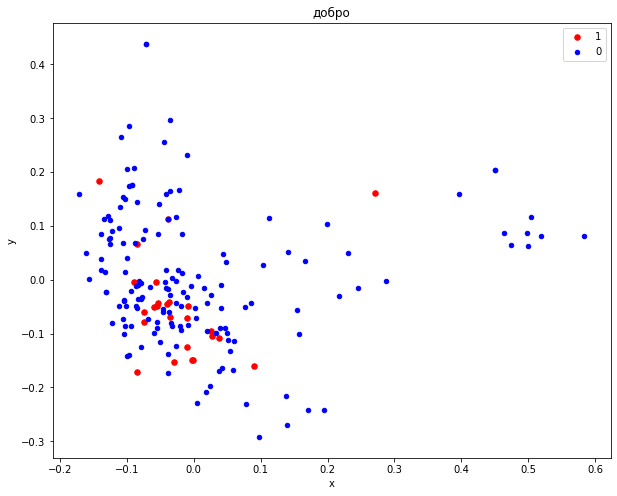

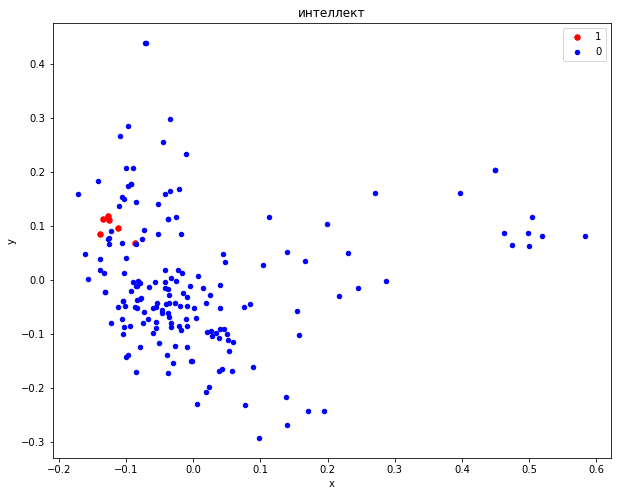

In [46]:
for i in range(direction_matrix.shape[1]):
    if bof_vectorizer.get_feature_names()[i] in ['интеллект', 'добро']:
        fig, ax = plt.subplots()
        fig.set_size_inches(10, 8)
        plt.title(bof_vectorizer.get_feature_names()[i])
        idx_1 = np.where(direction_matrix[:,i] == 1)
        idx_0 = np.where(direction_matrix[:,i] == 0)
        plt.scatter(Z[idx_1, 0], Z[idx_1, 1], s=30, c='r', marker="o", label='1')
        plt.scatter(Z[idx_0, 0], Z[idx_0, 1], s=20, c='b', marker="o", label='0')
        plt.ylabel('y')
        plt.xlabel('x')
        ax.legend()
        plt.show()

### Проверим корреляцию слов и тем

In [22]:
from sklearn.feature_selection import chi2

words = bof_vectorizer.get_feature_names()
for i in range(direction_matrix.shape[1]):
    features_chi2 = chi2(features_train, labels_train[:,i])
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' category:".format(words[i]))
    print("  . Most correlated unigrams: {}".format('; '.join(unigrams[-5:])))
    print("  . Most correlated bigrams: {}".format('; '.join(bigrams[-2:])))
    print("")
    if i == 5:
        break

# 'безразличие' category:
  . Most correlated unigrams: замечать; энергичный; безразличный; равнодушный; равнодушие
  . Most correlated bigrams: если быть; максим максим

# 'безысходность' category:
  . Most correlated unigrams: процентщица; раскольник; тупик; вечность; пространство
  . Most correlated bigrams: сила который; старуха процентщица

# 'бесконечность' category:
  . Most correlated unigrams: дьявол; остановить; мастер; мера; былой
  . Most correlated bigrams: потерять свой; любимый человек

# 'бескорыстие' category:
  . Most correlated unigrams: бросать; свойство; рассказчик; верность; забота
  . Most correlated bigrams: добрый человек; человек являться

# 'бескорыстность' category:
  . Most correlated unigrams: бросать; свойство; рассказчик; верность; забота
  . Most correlated bigrams: добрый человек; человек являться

# 'бессилие' category:
  . Most correlated unigrams: придавать; пространство; выход; предпринять; складываться
  . Most correlated bigrams: мочь привести; с

In [23]:
# df parsed
with open('Pickles/df_parsed.pickle', 'wb') as output:
    pickle.dump(df, output)
    
# features_train
with open('Pickles/features_train.pickle', 'wb') as output:
    pickle.dump(features_train, output)

# labels_train
with open('Pickles/labels_train.pickle', 'wb') as output:
    pickle.dump(labels_train, output)

# TF-IDF object
with open('Pickles/tfidf.pickle', 'wb') as output:
    pickle.dump(tfidf, output)